In [1]:
import json
import numpy as np
from scipy import stats
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
# import glmnet_python
# from glmnet_python import glmnet
# from glmnet_python import glmnetPredict
# from glmnet_python import glmnetPlot
# from glmnet_python import cvglmnet
# from glmnet_python import cvglmnetPredict
# from glmnet_python import cvglmnetPlot
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn import svm
from sklearn.neural_network import MLPClassifier
import codecs
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg

In [2]:
# VARIABLES TO ADJUST
# 'Mugs', 'Plates', 'Geometric', 'Cutlery', 'Ball'
family_to_select = 'Ball'
target = 'Index MPJ'
num_bins = 20
cv = 5
# C_par [0.2, 0.5, 1, 1.25, 1.5]
C_par = 0.2
# NMF Syns [4, 8, 12, 16, 24, 32, 48, 64]
nmf_syns = 4
l1vsl2 = 0.5
kin_labels = ["Thumb Rotate", "Thumb MPJ", "Thumb IJ", "Index MPJ", "Index PIJ", "Middle MPJ", "Middle PIJ", "Ring MPJ", "Ring PIJ", "Pinkie MPJ", "Pinkie PIJ", "Palm Arch", "Wrist Pitch", "Wrist Yaw", "Index Abd", "Pinkie Abd", "Ring Abd", "Middle Abd", "Thumb Abd"]
emg_labels = ['emg' + str(i) for i in range(0,64)]

In [3]:
# READING FILES AND CREATING DATASET
file_data = "./PyData/filtered_data.json"
file_eps = "./PyData/ep_labels.json"
file_task = "./PyData/task_labels.json"
file_allSyn = "./PyData/all_subjects_scores.json"
file_emg = "./PyData/emg_data.json"
file_nmf = "./PyData/W_"+str(nmf_syns)+".json"

with open(file_data, "r") as f:
    data = json.load(f)  # data[subjects][trials][joints]

with open(file_eps, "r") as g:
    eps = json.load(g)  # eps[subjects][trials]

with open(file_task, "r") as h:
    task = json.load(h)  # task[subjects][trials]

with open(file_allSyn, "r") as h:
    all_syn = json.load(h)  # all_syn[subjects X trials][joints]
    
with open(file_emg, "r") as f:
    emg_data = json.load(f)  # data[subjects][trials][sensors]
    
with open(file_nmf, "r") as f:
    nmf_data = json.load(f)  # nmf_data[subjects X trials][nmf syns]
    

In [4]:
# VECTORIZING DATA

vectorized_task = [x for sublist in task for x in sublist]  # Vectorization of tasks
vectorized_eps = [x for sublist in eps for x in sublist]  # Vectorization of eps
vectorized_data = [x for sublist in data for x in sublist]  # Vectorization of trials
vectorized_data = np.array(vectorized_data, dtype=float) # Conversion to float to we replace 'None' with 'NaN'
vectorized_emg_data = [x for sublist in emg_data for x in sublist]  # Vectorization of trials
vectorized_emg_data = np.array(vectorized_emg_data, dtype=float) # Conversion to float to we replace 'None' with 'NaN'
given_object = [x.split("_")[0] for x in vectorized_task]  # Vectorized given objects
ask_object = [x.split("_")[1] for x in vectorized_task]  # Vectorized asked objects
all_syn = np.array(all_syn, dtype=float) # Conversion to float to replace 'None' with 'NaN
# NMF require no preprocessing

In [5]:
# SPLIT BY TRIALS

tr_idx = [index for index, _ in enumerate(vectorized_task) if vectorized_task[index] != vectorized_task[index-1]]
tr_idx.append(len(vectorized_task))

# all these lists are [trials]x[timepoints per trial]
spl_task = [vectorized_task[tr_idx[i]:tr_idx[i+1]] for i, _ in enumerate(tr_idx) if i != len(tr_idx)-1]
spl_eps = [vectorized_eps[tr_idx[i]:tr_idx[i + 1]] for i, _ in enumerate(tr_idx) if i != len(tr_idx) - 1]
spl_dat = [vectorized_data[tr_idx[i]:tr_idx[i + 1]] for i, _ in enumerate(tr_idx) if i != len(tr_idx) - 1]
spl_emg = [vectorized_emg_data[tr_idx[i]:tr_idx[i + 1]] for i, _ in enumerate(tr_idx) if i != len(tr_idx) - 1]
spl_given = [given_object[tr_idx[i]:tr_idx[i + 1]] for i, _ in enumerate(tr_idx) if i != len(tr_idx) - 1]
spl_ask = [ask_object[tr_idx[i]:tr_idx[i + 1]] for i, _ in enumerate(tr_idx) if i != len(tr_idx) - 1]
spl_syn = [all_syn[tr_idx[i]:tr_idx[i + 1]] for i, _ in enumerate(tr_idx) if i != len(tr_idx) - 1]
spl_nmf = [nmf_data[tr_idx[i]:tr_idx[i + 1]] for i, _ in enumerate(tr_idx) if i != len(tr_idx) - 1]

# print(len(spl_task))


In [6]:
# SELECT TRIALS BY FAMILY

obj_fam = dict(
    CeramicMug = 'Mugs',
    Glass = 'Mugs',
    MetalMug = 'Mugs',
    CeramicPlate = 'Plates',
    MetalPlate = 'Plates',
    PlasticPlate = 'Plates',
    Cube = 'Geometric',
    Cylinder ='Geometric',
    Triangle ='Geometric',
    Fork = 'Cutlery',
    Knife ='Cutlery',
    Spoon ='Cutlery',
    PingPongBall = 'Ball',
    SquashBall='Ball',
    TennisBall='Ball'
)

fam_idx = list()
for it in range(len(spl_given)):
    if obj_fam[spl_given[it][0]] == family_to_select:
        fam_idx.append(it)

selected_task = [spl_task[idx] for idx in fam_idx]
selected_eps = [spl_eps[idx] for idx in fam_idx]
selected_dat = [spl_dat[idx] for idx in fam_idx]
selected_emg = [spl_emg[idx] for idx in fam_idx]
selected_given = [spl_given[idx] for idx in fam_idx]
selected_ask = [spl_ask[idx] for idx in fam_idx]
selected_syn = [spl_syn[idx] for idx in fam_idx]
selected_nmf = [spl_nmf[idx] for idx in fam_idx]

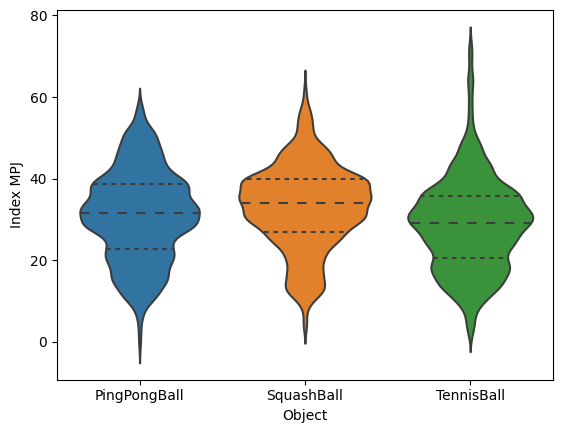

In [7]:
flat_kin = [item for sublist in selected_dat for item in sublist]
flat_giv = [item for sublist in selected_given for item in sublist]

# kin = stats.zscore(flat_kin, axis=0, nan_policy='omit')
aux_df = pd.DataFrame(flat_kin, columns=kin_labels)
aux_df['Object'] = flat_giv
aux_df.head


sns.violinplot(data=aux_df, x="Object", y=target, inner="quartile")
# sns.set(rc={'figure.figsize':(48,27)})
plt.show()

In [8]:
# DIVIDE BY EPs

# all these list are [trials]x[eps per trial]x[timepoints per ep]
final_task = list()
final_eps = list()
final_given = list()
final_ask = list()
# this lists are [trials]x[eps per trial]x[bins per ep]x[joints]
final_dat = list()
final_emg = list()
final_syn = list()
final_nmf = list()

for e in range(len(selected_eps)):

    ch_idx = [index for index, _ in enumerate(selected_eps[e]) if selected_eps[e][index] != selected_eps[e][index-1]]
    ch_idx.append(len(selected_eps[e]))
    if 0 not in ch_idx:
        ch_idx.insert(0, 0)

    sel_task = [selected_task[e][ch_idx[i]:ch_idx[i + 1]] for i, _ in enumerate(ch_idx) if i != len(ch_idx) - 1]
    final_task.append(sel_task)
    sel_eps = [selected_eps[e][ch_idx[i]:ch_idx[i + 1]] for i, _ in enumerate(ch_idx) if i != len(ch_idx) - 1]
    final_eps.append(sel_eps)
    sel_given = [selected_given[e][ch_idx[i]:ch_idx[i + 1]] for i, _ in enumerate(ch_idx) if i != len(ch_idx) - 1]
    final_given.append(sel_given)
    sel_ask = [selected_ask[e][ch_idx[i]:ch_idx[i + 1]] for i, _ in enumerate(ch_idx) if i != len(ch_idx) - 1]
    final_ask.append(sel_ask)

    sel_dat = [selected_dat[e][ch_idx[i]:ch_idx[i + 1]] for i, _ in enumerate(ch_idx) if i != len(ch_idx) - 1]
    sel_emg = [selected_emg[e][ch_idx[i]:ch_idx[i + 1]] for i, _ in enumerate(ch_idx) if i != len(ch_idx) - 1]
    sel_syn = [selected_syn[e][ch_idx[i]:ch_idx[i + 1]] for i, _ in enumerate(ch_idx) if i != len(ch_idx) - 1]
    sel_nmf = [selected_nmf[e][ch_idx[i]:ch_idx[i + 1]] for i, _ in enumerate(ch_idx) if i != len(ch_idx) - 1]
    
    # DIVIDE BY BINS
    aux = list()
    aux_syn = list()
    aux_emg = list()
    aux_nmf = list()
    
    for j in range(len(sel_dat)):
        div_dat = np.array_split(sel_dat[j], num_bins)
        div_emg = np.array_split(sel_emg[j], num_bins)
        div_syn = np.array_split(sel_syn[j], num_bins)
        div_nmf = np.array_split(sel_nmf[j], num_bins)
        
        dat_mean = [np.nanmean(x, axis=0) for x in div_dat]
        syn_mean = [np.nanmean(x, axis=0) for x in div_syn]
        emg_mean = [np.nanmean(x, axis=0) for x in div_emg]
        nmf_mean = [np.nanmean(x, axis=0) for x in div_nmf]
        
        aux.append(dat_mean)
        aux_syn.append(syn_mean)
        aux_emg.append(emg_mean)
        aux_nmf.append(nmf_mean)
        
        
    final_dat.append(aux)
    final_syn.append(aux_syn)
    final_emg.append(aux_emg)
    final_nmf.append(aux_nmf)


/tmp/ipykernel_425/1570130290.py:47: RuntimeWarning: Mean of empty slice
  dat_mean = [np.nanmean(x, axis=0) for x in div_dat]
/tmp/ipykernel_425/1570130290.py:48: RuntimeWarning: Mean of empty slice
  syn_mean = [np.nanmean(x, axis=0) for x in div_syn]
/tmp/ipykernel_425/1570130290.py:49: RuntimeWarning: Mean of empty slice
  emg_mean = [np.nanmean(x, axis=0) for x in div_emg]
/tmp/ipykernel_425/1570130290.py:50: RuntimeWarning: Mean of empty slice
  nmf_mean = [np.nanmean(x, axis=0) for x in div_nmf]


In [9]:
# SELECT TRIALS CV

total_acc = list()
unique_given = [final_given[i][0][0] for i in range(len(final_given))]  # unique object per trial
skf = StratifiedKFold(n_splits=cv)
for train, test in skf.split(final_dat, unique_given):

    train_given = [unique_given[x] for x in train]
    test_given = [unique_given[y] for y in test]
    train_data = [final_dat[x] for x in train]
    test_data = [final_dat[y] for y in test]
    train_emg = [final_emg[x] for x in train]
    test_emg = [final_emg[y] for y in test]
    train_syn = [final_syn[x] for x in train]
    test_syn = [final_syn[y] for y in test]
    train_nmf = [final_nmf[x] for x in train]
    test_nmf = [final_nmf[y] for y in test]

    # FOR SINGLE SOURCE CLASSIFICATION
    trn_dat = list()
    trn_emg = list()
    trn_lab = list()
    trn_syn = list()
    trn_nmf = list()

    for i in range(len(train_data)):
        for j in range(len(train_data[i])):
            aux = list()
            aux_syn = list()
            aux_emg = list()
            aux_nmf = list()
            for k in range(len(train_data[i][j])):
                aux = np.append(aux, train_data[i][j][k])
                aux_syn = np.append(aux_syn, train_syn[i][j][k])
                aux_emg = np.append(aux_emg, train_emg[i][j][k])
                aux_nmf = np.append(aux_nmf, train_nmf[i][j][k])
            if np.count_nonzero(np.isnan(aux)) == 0 and np.count_nonzero(np.isnan(aux_syn)) == 0 and np.count_nonzero(np.isnan(aux_emg)) == 0: # DISCARD EPs WITH ALL KINEMATICS OR ALL SYNERGIES AS NaN
                trn_dat.append(aux)  # size = Joints X bins
                trn_lab.append(train_given[i])
                trn_syn.append(aux_syn)  # size = Synergies X bins
                trn_emg.append(aux_emg)  # size = Electrodes X bins
                trn_nmf.append(aux_nmf)  # size = NMF Syns X bins

    tst_dat = list()
    tst_emg = list()
    tst_lab = list()
    tst_syn = list()
    tst_nmf = list()
    for i2 in range(len(test_data)):
        for j2 in range(len(test_data[i2])):
            aux2 = list()
            aux2_syn = list()
            aux2_emg = list()
            aux2_nmf = list()
            for k2 in range(len(test_data[i2][j2])):
                aux2 = np.append(aux2, test_data[i2][j2][k2])
                aux2_syn = np.append(aux2_syn, test_syn[i2][j2][k2])
                aux2_emg = np.append(aux2_emg, test_emg[i2][j2][k2])
                aux2_nmf = np.append(aux2_nmf, test_nmf[i2][j2][k2])
            if np.count_nonzero(np.isnan(aux2)) == 0 and np.count_nonzero(np.isnan(aux2_syn)) == 0 and np.count_nonzero(np.isnan(aux2_emg)) == 0: # DISCARD EPs WITH ALL KINEMATICS OR ALL SYNERGIES AS NaN
                tst_dat.append(aux2)
                tst_lab.append(test_given[i2])
                tst_syn.append(aux2_syn)
                tst_emg.append(aux2_emg)
                tst_nmf.append(aux2_nmf)
    
    # USING LOGISTIC REGRESSION
    # log_model = LogisticRegression(penalty='elasticnet', C=C_par, solver='saga', max_iter=25000, multi_class='multinomial', l1_ratio=l1vsl2)
#     log_model = LogisticRegression(penalty='elasticnet', C=C_par, solver='saga', max_iter=25000, multi_class='multinomial', l1_ratio=l1vsl2)
#     log_model.fit(trn_dat, trn_lab)
#     pred = log_model.predict_proba(tst_dat)

#     cl = log_model.classes_
#     hits = 0
#     for i in range(len(pred)):
#         if cl[np.argmax(pred[i])] == tst_lab[i]:
#             hits += 1
#     acc = round((hits/len(tst_lab))*100, 2)
#     total_acc.append(acc)
#     print("Hits: ", hits, " out of ", len(tst_lab), ". ", acc, "%")
    
    # WRITE WEIGHTS INTO A FILE
    # file_name = "./PyData/" + family_to_select + "_NMF_" + nmf_syns + ".csv"
    # file_name = "./PyData/NMF_weights_" + family_to_select + ".csv"
    # weights = log_model.coef_
    # resh = weights.reshape((weights.shape[0], int(weights.shape[1]/num_bins), num_bins))
    # mean_resh = np.mean(resh, axis=2)
    # df = pd.DataFrame(mean_resh, index=log_model.classes_)
    # df.to_csv(file_name, index=True, header=None, mode='a')
    # print("FILE UPDATED")

#     #  USING GLMNET
#     # lbl = LabelEncoder()
#     # dum = np.float64(lbl.fit_transform(trn_lab))
#     #
#     # cvfit = cvglmnet(x=np.array(trn_dat), y=dum, family='multinomial', alpha=0.5)
#     # pred = cvglmnetPredict(cvfit, np.array(tst_dat), ptype='class')
#     #
#     # dum_res = np.float64(lbl.fit_transform(tst_lab))
#     # hits = 0
#     # for i in range(len(pred)):
#     #     if pred[i] == dum_res[i]:
#     #         hits += 1
#     # acc = round((hits/len(tst_lab))*100, 2)
#     # total_acc.append(acc)
#     # print("Hits: ", hits, " out of ", len(tst_lab), ". ", acc, "%")

#     # USING SVM
#     # clf = svm.SVC(C=25, kernel='poly', degree=3, decision_function_shape='ovo')  # 45.91
#     # clf.fit(np.array(trn_dat), trn_lab)
#     # pred = clf.predict(np.array(tst_dat))
#     # hits = 0
#     # for i in range(len(pred)):
#     #     if pred[i] == tst_lab[i]:
#     #         hits += 1
#     # acc = round((hits/len(tst_lab))*100, 2)
#     # total_acc.append(acc)
#     # print("Hits: ", hits, " out of ", len(tst_lab), ". ", acc, "%")

#     # USING ANN
#     # num_hidden_layers = 4
#     # layers = np.ceil(np.geomspace(len(trn_dat[0]), 3, num_hidden_layers+2)).astype(int)
#     # clf = MLPClassifier(solver='adam', alpha=20, hidden_layer_sizes=(layers[1:len(layers)-1]), random_state=1, max_iter=100000, activation='tanh')
#     # clf.fit(np.array(trn_dat), trn_lab)
#     # pred = clf.predict(np.array(tst_dat))
#     # hits = 0
#     # for i in range(len(pred)):
#     #     if pred[i] == tst_lab[i]:
#     #         hits += 1
#     # acc = round((hits/len(tst_lab))*100, 2)
#     # total_acc.append(acc)
#     # print("Hits: ", hits, " out of ", len(tst_lab), ". ", acc, "%")
# ##########################################################################
#     # FOR MULTIPLE SOURCE CLASSIFICATION
#     trn_kin = list()
#     trn_emg = list()
    
#     trn_lab = list()

#     for i in range(len(train_data)):
#         for j in range(len(train_data[i])):
#             aux = list()
#             aux_emg = list()

#             for k in range(len(train_data[i][j])):
#                 aux = np.append(aux, train_data[i][j][k])
#                 aux_emg = np.append(aux_emg, train_emg[i][j][k])
                
#             if np.count_nonzero(np.isnan(aux)) == 0 and np.count_nonzero(np.isnan(aux_emg)) == 0: # DISCARD EPs WITH ALL KINEMATICS OR ALL SYNERGIES AS NaN
#                 trn_lab.append(train_given[i])
#                 trn_kin.append(aux) 
#                 trn_emg.append(aux_emg)
                
                
#     trn_dat = np.concatenate((trn_kin, trn_emg), axis=1)


#     # tst_dat = list()
#     tst_kin = list()
#     tst_emg = list()
#     tst_lab = list()
#     for i2 in range(len(test_data)):
#         for j2 in range(len(test_data[i2])):
#             aux2 = list()
#             aux2_emg = list()
#             for k2 in range(len(test_data[i2][j2])):
#                 aux2 = np.append(aux2, test_data[i2][j2][k2])
#                 aux2_emg = np.append(aux2_emg, test_emg[i2][j2][k2])
                
#             if np.count_nonzero(np.isnan(aux2)) == 0 and np.count_nonzero(np.isnan(aux2_emg)) == 0: # DISCARD EPs WITH ALL KINEMATICS OR ALL SYNERGIES AS NaN
#                 tst_kin.append(aux2)
#                 tst_emg.append(aux2_emg)
#                 tst_lab.append(test_given[i2])
                
                
#     tst_dat = np.concatenate((tst_kin, tst_emg), axis=1)
                
#     # USING LOGISTIC REGRESSION
#     log_model = LogisticRegression(penalty='elasticnet', C=C_par, solver='saga', max_iter=25000, multi_class='multinomial', n_jobs=-1, l1_ratio=l1vsl2)
#     log_model.fit(trn_dat_norm, trn_lab)
#     weights = log_model.coef_
#     # print("Size Weights: ", weights.shape)
#     # print("Classes: ", log_model.classes_)
    
#     # WRITE WEIGHTS INTO A FILE
#     file_name = "./PyData/KIN_EMG_Norm_weights_N05_" + family_to_select + ".csv"
#     # weights = log_model.coef_
#     resh = weights.reshape((weights.shape[0], int(weights.shape[1]/num_bins), num_bins))
#     mean_resh = np.mean(np.abs(resh), axis=2)
#     df = pd.DataFrame(mean_resh, index=log_model.classes_)
#     df.to_csv(file_name, index=True, header=None, mode='a')
#     print("FILE UPDATED")
    
#     # GET PREDICTIONS
#     pred = log_model.predict_proba(tst_dat_norm)
#     cl = log_model.classes_
#     hits = 0
#     for i in range(len(pred)):
#         if cl[np.argmax(pred[i])] == tst_lab[i]:
#             hits += 1
#     acc = round((hits/len(tst_lab))*100, 2)
#     total_acc.append(acc)
#     print("Hits: ", hits, " out of ", len(tst_lab), ". ", acc, "%")

    #  USING GLMNET
    # lbl = LabelEncoder()
    # dum = np.float64(lbl.fit_transform(trn_lab))
    #
    # cvfit = cvglmnet(x=np.array(trn_dat), y=dum, family='multinomial', alpha=0.5)
    # pred = cvglmnetPredict(cvfit, np.array(tst_dat), ptype='class')
    #
    # dum_res = np.float64(lbl.fit_transform(tst_lab))
    # hits = 0
    # for i in range(len(pred)):
    #     if pred[i] == dum_res[i]:
    #         hits += 1
    # acc = round((hits/len(tst_lab))*100, 2)
    # total_acc.append(acc)
    # print("Hits: ", hits, " out of ", len(tst_lab), ". ", acc, "%")

    # USING SVM
    # clf = svm.SVC(C=25, kernel='poly', degree=3, decision_function_shape='ovo')  # 45.91
    # clf.fit(np.array(trn_dat), trn_lab)
    # pred = clf.predict(np.array(tst_dat))
    # hits = 0
    # for i in range(len(pred)):
    #     if pred[i] == tst_lab[i]:
    #         hits += 1
    # acc = round((hits/len(tst_lab))*100, 2)
    # total_acc.append(acc)
    # print("Hits: ", hits, " out of ", len(tst_lab), ". ", acc, "%")

    # USING ANN
    # num_hidden_layers = 4
    # layers = np.ceil(np.geomspace(len(trn_dat[0]), 3, num_hidden_layers+2)).astype(int)
    # clf = MLPClassifier(solver='adam', alpha=20, hidden_layer_sizes=(layers[1:len(layers)-1]), random_state=1, max_iter=100000, activation='tanh')
    # clf.fit(np.array(trn_dat), trn_lab)
    # pred = clf.predict(np.array(tst_dat))
    # hits = 0
    # for i in range(len(pred)):
    #     if pred[i] == tst_lab[i]:
    #         hits += 1
    # acc = round((hits/len(tst_lab))*100, 2)
    # total_acc.append(acc)
    # print("Hits: ", hits, " out of ", len(tst_lab), ". ", acc, "%")

# print("|| FAMILY: ", family_to_select, " || Mean accuracy after ", cv, " folds with ", num_bins, " bins per EP: ", round(np.mean(total_acc), 2), " % ||")
# # print("|| FAMILY: ", family_to_select,  " || Bins per EP: ", num_bins, " ||")
# print("DONE!")


In [10]:
#### KINEMATICS
# kin_labels = ["Thumb Rotate", "Thumb MPJ", "Thumb IJ", "Index MPJ", "Index PIJ", "Middle MPJ", "Middle PIJ", "Ring MPJ", "Ring PIJ", "Pinkie MPJ", "Pinkie PIJ", "Palm Arch", "Wrist Pitch", "Wrist Yaw", "Index Abd", "Pinkie Abd", "Ring Abd", "Middle Abd", "Thumb Abd"]
# z_score_kin = stats.zscore(vectorized_data, axis=0, nan_policy='omit')
# new_df = pd.DataFrame(z_score_kin, columns=kin_labels)
# new_df['Object'] = given_object

# # select trials by object
# selected = new_df.loc[(new_df['Object'] == 'CeramicMug') | (new_df['Object'] == 'Glass') | (new_df['Object'] == 'MetalMug')]

# res_anova_index = pg.anova(data=selected, dv='Index MPJ', between='Object', detailed=True)
# res_pairwise_index = pg.pairwise_tukey(data=selected, dv='Index MPJ', between='Object')
# print(res_anova_index['p-unc'].iloc[0])
# print(res_pairwise_index['p-tukey'])

# res_anova_thumb = pg.anova(data=selected, dv='Thumb Abd', between='Object', detailed=True)
# res_pairwise_thumb = pg.pairwise_tukey(data=selected, dv='Thumb Abd', between='Object')
# # print(res_anova_thumb)
# # print(res_pairwise_thumb)

# sns.violinplot(data=selected, x="Object", y="Index MPJ", inner="quartile")
# sns.set(rc={'figure.figsize':(48,27)})
# plt.show()

### EMG
# emg_labels = ['emg' + str(i) for i in range(0,64)]
# z_score_emg = stats.zscore(vectorized_emg_data, axis=0, nan_policy='omit')
# new_df_emg = pd.DataFrame(z_score_emg, columns=emg_labels)
# new_df_emg['Object'] = given_object
# # print(new_df_emg)

# selected_emg = new_df_emg.loc[(new_df_emg['Object'] == 'CeramicMug') | (new_df_emg['Object'] == 'Glass') | (new_df_emg['Object'] == 'MetalMug')]
# # print(selected_emg['emg18'])
# res_anova_index_emg = pg.anova(data=selected_emg, dv='emg18', between='Object', detailed=True)
# res_pairwise_index_emg = pg.pairwise_tukey(data=selected_emg, dv='emg18', between='Object')
# print(res_anova_index_emg)
# print(res_pairwise_index_emg)
# # print(res_anova_index_emg['p-unc'].iloc[0])
# # print(res_pairwise_index_emg['p-tukey'])


# sns.violinplot(data=selected_emg, x="Object", y="emg18", inner="quartile")
# sns.set(rc={'figure.figsize':(48,27)})
# plt.show()

# tot_dat = np.concatenate((trn_dat_norm, tst_dat_norm), axis=0)
# obj_labels = np.append(trn_lab, tst_lab)

# sensor_labels = np.append(kin_labels, emg_labels)

# fin_tot_dat = list()
# labs = list()
# for i in range(len(tot_dat)):
#     aux = np.array_split(tot_dat[i], num_bins)
#     [fin_tot_dat.append(iter) for iter in aux]
#     [labs.append(obj_labels[i]) for iter in aux]
#     # labs.append(np.repeat(labels[i], num_bins))

# new_df = pd.DataFrame(fin_tot_dat, columns=sensor_labels)
# new_df['Object'] = labs

# # target = 'Middle Abd'

# res_anova_1 = pg.anova(data=new_df, dv=target, between='Object', detailed=True).round(3)
# res_pairwise_t = pg.pairwise_tukey(data=new_df, dv=target, between='Object').round(3)
# res_pairwise_1 = pg.pairwise_tests(data=new_df, dv=target, between='Object', padjust='bonf').round(3)

# print("Target: ", target) 

# print("\nANOVA p-val: ",  str(res_anova_1['p-unc'][0]))
# print("\nTukey Pairwise p-val:")
# for it in range(res_pairwise_t.shape[0]):
#     print(str(res_pairwise_t['A'][it]), str(res_pairwise_t['B'][it]), str(res_pairwise_t['p-tukey'][it]))
    
# print("\nBonferroni t-test p-val:")
# for it in range(res_pairwise_1.shape[0]):
#     print(str(res_pairwise_1['A'][it]) + " " + str(res_pairwise_1['B'][it]) + " " + str(res_pairwise_1['p-corr'][it]))
    
# sns.violinplot(data=new_df, x="Object", y=target, inner="quartile")
# # sns.set(rc={'figure.figsize':(48,27)})
# plt.show()

# save_file = "./PyData/Boxplot_" + family_to_select + "_" + target.replace(" ", "") + ".png"
# # plt.savefig(save_file, bbox_inches="tight")
# print("\nSaved ", save_file)